In [835]:
import matplotlib.pyplot as plt
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit
import random as rd
from sympy import *
import tensorflow as tf
import tensorflow_quantum as tfq
import math
import re
import itertools
from numpy import linalg as LA
from scipy.stats import poisson
import time
from random import choices
from random import  uniform

In [836]:
k = 4 #length of clauses
n_var = 8 #number of variables
nqubits = n_var #number of qubits in the circuit
all_vars = [i for i in range(-n_var,n_var+1)]
all_vars = [i for i in all_vars if i != 0]

p = 6 #number of layers for QAOA circuit
qubits = [cirq.GridQubit(0,i) for i in range(nqubits)]
parameters = symbols("q0:%d" % (2*p))

In [837]:
parameters

(q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11)

In [838]:
r_by_k = {2 : 1, 3: 6.43, 4: 20.43, 5 : 45.7, 6: 70.21, 8: 176.54, 10: 708.92, 16: 45425.2}

def generate_instance(k: int, n: int) -> np.ndarray:
    #generate an instance of random k-SAT with n variables in the satisfiability threshold
    if not (r := r_by_k.get(k)):
        raise ValueError(f"k must be in {list(r_by_k)} (got {k})")
    m = poisson(r*n).rvs()
    #return np.random.choice(all_vars, size=(m, k))
    all_variables = []
    all_signs = []
    for i in range(m):
        #all_signs.append([rd.choice(l) for i in range(k)])
        all_variables.append(choices(all_vars, k = k))

    all_variables = np.array(all_variables)
    #all_signs = np.array(all_signs)
    return all_variables

In [839]:
def generate_binary_strings(bit_count):
    binary_strings = []
    
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    genbin(bit_count)
    return binary_strings

In [840]:
def dimacs_writer(dimacs_filename, cnf_array):
    #writes the dimacs file with the CNF
    cnf = cnf_array
    cnf_length = len(cnf)
    n_sat = len(cnf[0])
    var_num = np.max(cnf) 
    with open(dimacs_filename, "w") as f:

        f.write('c DIMACS file CNF '+str(n_sat)+'-SAT \n')
        f.write("p cnf {} {}\n".format(var_num, cnf_length))
        
        for i, clause in enumerate(cnf):
            line = clause.tolist()
            if i == cnf_length - 1:
                s = ' '.join(str(x) for x in line)+' 0'
                f.write(s)
            else: 
                s = ' '.join(str(x) for x in line)+' 0 \n'
                f.write(s)

In [841]:
class Verifier():
    #verifier from Qiskit page, takes a bit string and checks if cnf is satisfied
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [842]:
valid_keys = []
dimacs_file = "data/random_cnf_BM.dimacs" 
binary_strings = generate_binary_strings(nqubits)

while not valid_keys:
    #only accepts satisfiable CNFs
    inst = generate_instance(k, n_var)
    dimacs_writer(dimacs_file, inst)
    v = Verifier(dimacs_file)
    
    for key in binary_strings:
        if v.is_correct(key) == True:
            print(key) 
            valid_keys.append(key)

10101011


In [843]:
def my_gate(c, index):
    g = c * cirq.Z.on(qubits[index]) + cirq.I.on(qubits[index])
    return g

In [844]:
def ham_layer(diagonal, circuit, qubits, par):
    
    l = cirq.DiagonalGate(diagonal)._decompose_(qubits)
    l.pop(0)
    for j, gate in enumerate(l):

        if j % 2 == 0:
            dictn = gate._json_dict_()
            my_string = str(dictn['gate'])
            my_other_string = str(dictn['qubits'])
            number_p = re.findall("\d+\.\d+", my_string)
            res_p = [eval(i) for i in number_p]
            if '-' in my_string:
                sign = -1
            else:
                sign = 1
            
            number_q = re.findall(r'\d+', my_other_string)
            res_q = [eval(i) for i in number_q]
            kernel = sign*par*res_p[0]*np.pi
            rzgate = cirq.rz(kernel).on(qubits[res_q[1]])
            circuit.append(rzgate)
        else:
            circuit.append(gate)

In [845]:
def mixing_circuit(circuit, qubits, par):
    for i in range(len(qubits)):
        circuit.append(cirq.rx(par).on(qubits[i]))
    return circuit

In [846]:
def circuit_from_dimacs(dimacs_file, binary_strings, nqubits, qubits, layers, parameters):

    qubits = []
    for i in range(nqubits):
        qubits.append(cirq.GridQubit(0,i))

    with open(dimacs_file, 'r') as f:
            dimacs = f.read()
    
    unsat_list = []

    for key in binary_strings:
        guess = [bool(int(x)) for x in key][::-1]

        clause_eval_list = []
        counter = 0
        for j, line in enumerate(dimacs.split('\n')):

            line = line.strip(' 0')
            clause_eval = False

            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    #line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if j > 1:
                counter += 1
                clause_eval_list.append(clause_eval)
        unsat_clauses = counter - sum(clause_eval_list)
        unsat_list.append(unsat_clauses)
    sum_unsat = sum(unsat_list)
    diagonal = unsat_list#[x / sum_unsat for x in unsat_list]
    print(unsat_list, diagonal)

    #diagonal = unsat_list
    combinations = [p for p in itertools.product([1, -1], repeat=nqubits)]
    ops_list = []
    for j, combination in enumerate(combinations):
        ops_list.append((diagonal[j]/2**nqubits)*math.prod([my_gate(combination[i], i) for i in range(nqubits)]))

    cost = np.sum(ops_list)
    cost_m = cost.matrix()
    gs_energy = np.real(min(LA.eig(cost_m)[0]))
    
    qaoa_circuit = cirq.Circuit()
    num_param = 2 * layers

    for i in range(layers):
        ham_layer(diagonal, qaoa_circuit, qubits, parameters[2 * i])
        mixing_circuit(qaoa_circuit, qubits, parameters[2 * i + 1])

    return qaoa_circuit, cost

In [847]:
qaoa_circuit, cost = circuit_from_dimacs(dimacs_file, binary_strings, nqubits, qubits, p, parameters)

[10, 10, 10, 9, 11, 12, 10, 7, 12, 14, 9, 9, 10, 13, 8, 6, 12, 12, 13, 13, 12, 13, 12, 10, 12, 13, 10, 10, 10, 12, 9, 7, 10, 10, 8, 8, 9, 9, 8, 6, 12, 12, 6, 6, 8, 9, 5, 4, 10, 8, 10, 9, 9, 7, 9, 6, 13, 11, 7, 6, 10, 9, 6, 4, 9, 12, 5, 7, 11, 14, 7, 5, 12, 14, 9, 9, 9, 11, 8, 4, 11, 14, 6, 10, 13, 16, 8, 8, 13, 13, 9, 9, 11, 11, 9, 5, 13, 14, 7, 8, 11, 12, 7, 5, 13, 13, 7, 7, 9, 10, 7, 5, 12, 10, 7, 7, 11, 9, 7, 4, 14, 10, 7, 5, 12, 9, 8, 4, 14, 8, 11, 7, 16, 13, 13, 9, 11, 7, 8, 6, 10, 10, 9, 8, 14, 8, 14, 10, 15, 11, 15, 10, 12, 7, 11, 8, 11, 9, 12, 9, 9, 7, 5, 4, 11, 11, 8, 7, 8, 4, 2, 0, 7, 7, 4, 4, 10, 8, 10, 9, 10, 9, 10, 8, 14, 10, 9, 7, 12, 11, 9, 8, 10, 7, 6, 5, 12, 10, 9, 5, 9, 6, 6, 5, 6, 5, 6, 3, 12, 9, 8, 8, 14, 11, 11, 7, 12, 7, 8, 6, 10, 6, 9, 4, 12, 11, 5, 5, 11, 11, 6, 4, 11, 8, 3, 2, 8, 8, 4, 3, 13, 11, 8, 8, 11, 9, 7, 4, 17, 12, 8, 6, 14, 11, 8, 5] [10, 10, 10, 9, 11, 12, 10, 7, 12, 14, 9, 9, 10, 13, 8, 6, 12, 12, 13, 13, 12, 13, 12, 10, 12, 13, 10, 10, 10, 12, 9, 7,

In [848]:
cost_m = cost.matrix()
gs_energy = np.real(min(LA.eig(cost_m)[0]))

initial = cirq.Circuit()

for qubit in qubits:
    initial.append(cirq.H(qubit)) #applying Hadamard to all qubits before running circuit

inputs = tfq.convert_to_tensor([initial])
ins = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.string)
outs = tfq.layers.PQC(qaoa_circuit, cost)(ins)
ksat = tf.keras.models.Model(inputs = ins, outputs = outs)
opt = tf.keras.optimizers.Adam(learning_rate = 0.5e-3)

all_pars = [0.01*(-1)**(-i%2) for i in range(1,2*p+1)]
#all_pars = [0.12, 0.9, 0.2, 0.7, 0.35, 0.8, 0.4, 0.6]
ksat.trainable_variables[0].assign(all_pars) #initializing parameters with carefully chosen values

<tf.Variable 'UnreadVariable' shape=(12,) dtype=float32, numpy=
array([-0.01,  0.01, -0.01,  0.01, -0.01,  0.01, -0.01,  0.01, -0.01,
        0.01, -0.01,  0.01], dtype=float32)>

In [849]:
losses = []
start = time.time()

j = 0
epochs = 2.5e4

while j < epochs:

    with tf.GradientTape() as tape:
        error = ksat(inputs)
    
    grads = tape.gradient(error, ksat.trainable_variables)
    opt.apply_gradients(zip(grads, ksat.trainable_variables))
    error = error.numpy()[0,0]
    losses.append(error)
    print('Epoch is '+str(j)+' and absolute value of (ground state energy - error) is ' + str(abs(gs_energy - error)), end = '\r')
   
    j += 1
    
end = time.time()

In [850]:
print("Time spent in training: ", end - start)

Time spent in training:  324002.7866780758


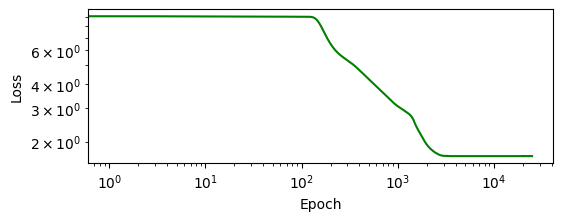

In [ ]:
plt.figure(figsize=(6,2))
plt.plot(losses, color = "green")
plt.axhline(y = 0, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
#plt.savefig("TSP_losses")

In [ ]:
def to_dec(x):
    return int("".join(str(i) for i in x), 2) 

In [ ]:
params = ksat.trainable_variables

In [ ]:
params

[<tf.Variable 'parameters:0' shape=(12,) dtype=float32, numpy=
 array([0.15621413, 1.0753937 , 0.49862027, 0.37640744, 0.2632184 ,
        0.9961199 , 0.33156207, 0.8640275 , 0.4139254 , 0.69913036,
        0.47035497, 0.6167302 ], dtype=float32)>]

In [ ]:
start = time.time()

sample_circuit = tfq.layers.AddCircuit()(inputs, append=qaoa_circuit)
output = tfq.layers.Sample()(sample_circuit, symbol_names=parameters, symbol_values=params, repetitions = 2048)

end = time.time()

print("Time spent in sampling: ",end - start)

quantum_preds = []
data = []
for bits in output.values:
    temp = []
    data.append(to_dec(bits.numpy()))
    for pos, bit in enumerate(bits):
        if bit == 1:
            temp.append(pos)
    quantum_preds.append(temp)

Time spent in sampling:  0.4468681812286377


In [ ]:
valid_keys

['10101011']

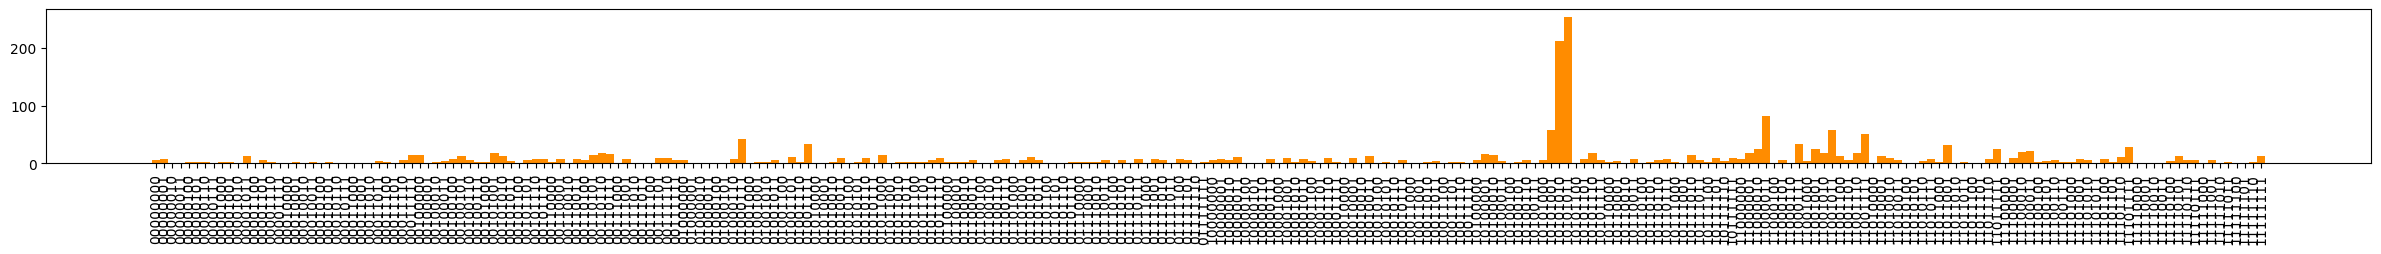

In [ ]:
xticks = range(0, 2**nqubits)
xtick_labels = list(map(lambda x: format(x, "0"+str(nqubits)+"b"), xticks))
bins = np.arange(0, 2**nqubits + 1) - 0.5

plt.figure(figsize=(30,2))
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(data, bins=bins, color = "darkorange", lw=0)
#plt.savefig('hist_custom_sat.pdf')
plt.show()